#### Import required packages

In [1]:
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE, RFECV

from statsmodels.stats.multitest import multipletests

from triglav import Triglav, CLRTransformer, ETCProx

from boruta import BorutaPy

import shap as sh

import sage as sg

import numpy as np

import pandas as pd

from random import shuffle

import seaborn as sns

from matplotlib import pyplot as plt

from skbio.stats.composition import clr, multiplicative_replacement, closure

from stability import *

d:\miniconda3\envs\testLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\miniconda3\envs\testLM\Lib\site-packages\shap\utils\_clustering.py:34: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
d:\miniconda3\envs\testLM\Lib\site-packages\shap\utils\_clustering.py:53: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba

#### Read in taxonomic data and select high-confidence ASVs

In [2]:
if __name__ == "__main__":

    #Read in ASV table
    X = pd.read_csv("Diseased Gut/ESV.table", index_col=0, sep="\t")
    X_features = X.index.values #Get features
    X_index = [s_name.split("_")[0] for s_name in X.columns.values] #Get the right index
    X_original = X.transpose()
    X_original.index = X_index #Fix the index so it can be ordered
    
    # Read in taxa data
    taxa_tab = pd.read_csv(
        "Diseased Gut/rdp.out.tmp", delimiter="\t", header=None
    ).values

    #Convert taxa tab into a dictionary for quick searching
    taxa_dict = {t[0]: np.asarray(t)[1:] for t in taxa_tab}
    
    # Keep all ASVs assigned to Bacteria and Archaea, remove Cyanobacteria and Chloroplasts
    idx = np.where(
        ((taxa_tab[:, 2] == "Bacteria") | (taxa_tab[:, 2] == "Archaea")), True, False
    )
    taxa_tab = taxa_tab[idx]
    idx = np.where(taxa_tab[:, 5] != "Cyanobacteria/Chloroplast", True, False)
    taxa_tab = taxa_tab[idx]
    X_selected = set([x[0] for x in taxa_tab])
    taxa_tab_ss = {x[0]: x for x in taxa_tab}

    # Get names of high confidence features
    n_list = [4, 7, 10, 13, 16, 19]
    asv_name = []

    for entry in X_features:
        if entry in taxa_dict:
            if float(taxa_dict[entry][-1]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-3], entry))

            elif float(taxa_dict[entry][-4]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-6], entry))

            elif float(taxa_dict[entry][-7]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-9], entry))

            elif float(taxa_dict[entry][-10]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-12], entry))

            elif float(taxa_dict[entry][-13]) > 0.8:
                asv_name.append("%s-%s" % (taxa_dict[entry][-15], entry))

            else:
                asv_name.append("Unclassified-%s" % entry)
    
    asv_name = np.asarray(asv_name)

In [3]:
    print(asv_name.shape)
    print(X_features.shape)
    print(X_original.shape)
    print(X_original)
    print(asv_name)

(3318,)
(3318,)
(214, 3318)
#OTU ID     Zotu1  Zotu10  Zotu100  Zotu1000  Zotu1001  Zotu1002  Zotu1003   
SRR8534033    926       1        0         0         0         0         0  \
SRR8534034  38586      14        1         0         0         0         0   
SRR8534035  49718    1069        1         0         2         0         0   
SRR8534036   1016     236        0         0         0         0         0   
SRR8534037   4247    3416        0         0         0         0         0   
...           ...     ...      ...       ...       ...       ...       ...   
SRR8534250   5231    2880        0         0         1         0         0   
SRR8534251    636     145        0         0         0         0         0   
SRR8534252   3026     347      332         0         0         0         0   
SRR8534253    111     163        0         0         0         0         0   
SRR8534254  12386    2485        0         0         0         0         0   

#OTU ID     Zotu1004  Zotu1005  Zot

#### Read in metadata and order X

In [4]:
    # Read in metadata
    meta = pd.read_csv("Diseased Gut/metadata.csv", index_col=0)
    meta = meta[["Sample Name", "Host_disease", "Timepoint"]]

    # Correct locations so they are more informative
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "CD", "Crohn's Disease", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "RA", "Rheumatoid Arthritis", meta["Host_disease"]
    )
    meta["Host_diseaes"] = np.where(
        meta["Host_disease"] == "MS", "Multiple Sclerosis", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "US", "Ulcerative Colitis", meta["Host_disease"]
    )
    meta["Host_disease"] = np.where(
        meta["Host_disease"] == "HC", "Healthy Control", meta["Host_disease"]
    )
    
    #Order samples according to the metadata
    X_original = X_original.loc[meta.index]


In [5]:
    print(meta)
    print(X_original)

            Sample Name          Host_disease  Timepoint          Host_diseaes
SRR8534151       1003.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
SRR8534152       1003.2  Rheumatoid Arthritis          2  Rheumatoid Arthritis
SRR8534149       1021.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
SRR8534083       1021.2  Rheumatoid Arthritis          2  Rheumatoid Arthritis
SRR8534155       1024.1  Rheumatoid Arthritis          1  Rheumatoid Arthritis
...                 ...                   ...        ...                   ...
SRR8534199       8399.2                    UC          2                    UC
SRR8534200       8407.1       Crohn's Disease          1       Crohn's Disease
SRR8534125       8407.2       Crohn's Disease          2       Crohn's Disease
SRR8534128       8702.1                    UC          1                    UC
SRR8534126       8702.2                    UC          2                    UC

[198 rows x 4 columns]
#OTU ID     Zotu1  Zotu10  Z

#### Get the group metadata (Sample Name)

In [6]:
    # Get groups
    groups = meta["Sample Name"].astype(str).values
    groups = np.asarray([x.split(".")[0] for x in groups])
    
    # List of phenotypes/datasets to test
    pheno = "Crohn's Disease-Healthy Control"

    pheno_a, pheno_b = pheno.split("-")

    idx = np.where(
        ((meta["Host_disease"] == pheno_a) | (meta["Host_disease"] == pheno_b)),
        True,
        False,
    )

    y = meta[idx]["Host_disease"]
    y = y.values
    
    X_signal = X_original[idx]
    
    groups = groups[idx]


In [7]:
    print(y)
    print(groups)
    print(X_signal)

['Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disease" "Crohn's Disease"
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 "Crohn's Disease" "Crohn's Disease" 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' 'Healthy Control' 'Healthy Control'
 'Healthy Control' 'Healthy Control' "Crohn's Disea

#### Collect Data

All Features:  3318
Reduced Features:  938


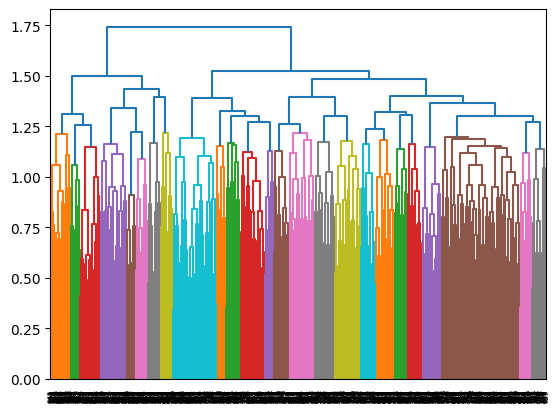

In [8]:
    # Remove very rare ASVs (<= 4 occurances)
    X_removed = np.where(X_signal.values > 0, True, False)
    occ = np.where(X_removed.sum(axis = 0) > 4, True, False)
    X_removed = X_signal.values[:, occ]
    reduced_features = asv_name[occ]
    
    print("All Features: ", X_signal.shape[1])
    print("Reduced Features: ", X_removed.shape[1])
    
    # Get a threshold from the dendrogram
    tg_model = Triglav(n_jobs = 10, 
                       verbose = 0,
                       n_iter_fwer = 5,
                       p_1 = 0.70,
                       p_2 = 0.4,
                       transformer = CLRTransformer(),
                       run_stage_2 = True, 
                       alpha = 0.01,
                       metric = "correlation", 
                       linkage = "complete")
        
    fig = tg_model.visualize_hclust(X_removed, y)
    plt.show()
    plt.close()

#### Loop through samples and select features / calculate generalization performance

In [9]:
    arr = []

    idx = np.asarray([i for i in range(0, X_removed.shape[1])])
    
    for i in range(10):
        splitter = StratifiedGroupKFold(n_splits = 5, random_state = i, shuffle = True)

        #Set the iteration counter
        j = 1

        for train, test in splitter.split(X_removed, y, groups):

            X_train = X_removed[train]
            y_train = y[train]

            X_test = X_removed[test]
            y_test = y[test]

            # Control - Get base balanced accuracy score
            clf = ExtraTreesClassifier(128, random_state = i).fit(clr(multiplicative_replacement(closure(X_train))), np.asarray(y_train))
            p = clf.predict(clr(multiplicative_replacement(closure(X_test))))
            BA = balanced_accuracy_score(y_test, p)

            tmp = [BA, "Control", ";".join([str(j) for j in range(X_train.shape[1])]), X_train.shape[1], j]

            arr.append(tmp)

            print(BA, "Control")

            #Mutual Information
            p_sel = mutual_info_classif(clr(multiplicative_replacement(closure(X_train))), y_train, discrete_features=False)
            p_idx = [(p_sel[j], j) for j in range(X_train.shape[1])]
            p_idx.sort()
            p_idx = p_idx[::-1]
            p_sel = [p_idx[j][1] for j in range(20)]
            p_sel.sort()
            p_sel = np.asarray(p_sel)

            clf = ExtraTreesClassifier(128, random_state = i).fit(clr(multiplicative_replacement(closure(X_train)))[:, p_sel], np.asarray(y_train))
            p = clf.predict(clr(multiplicative_replacement(closure(X_test)))[:, p_sel])
            BA = balanced_accuracy_score(y_test, p)

            tmp = [BA, "Mutual Information", ";".join(p_sel.astype(str)), len(p_sel), j]

            arr.append(tmp)

            print(BA, "Mutual Information")

            #ANOVA
            p_sel = f_classif(clr(multiplicative_replacement(closure(X_train))), y_train)[1]
            p_sel = multipletests(p_sel, 0.05, method = "fdr_bh")[0]
            p_sel = np.asarray([j for j in range(X_train.shape[1])])[p_sel]

            clf = ExtraTreesClassifier(128, random_state = i).fit(clr(multiplicative_replacement(closure(X_train)))[:, p_sel], np.asarray(y_train))
            p = clf.predict(clr(multiplicative_replacement(closure(X_test)))[:, p_sel])
            BA = balanced_accuracy_score(y_test, p)

            tmp = [BA, "ANOVA", ";".join(p_sel.astype(str)), len(p_sel), j]

            arr.append(tmp)

            print(BA, "ANOVA")

            #Triglav - All
            clf_a = Triglav(n_jobs = 15,
                            estimator = ExtraTreesClassifier(512, max_depth = 7, bootstrap = True),
                            verbose = 0,
                            n_iter_fwer = 5,
                            p_1 = 0.70,
                            p_2 = 0.4,
                            transformer = CLRTransformer(),
                            run_stage_2 = False, 
                            alpha = 0.01,
                            metric = "correlation", 
                            linkage = "complete",
                            thresh = 0.5).fit(X_train, np.asarray(y_train))
                       
            p_sel = clf_a.selected_

            clf = ExtraTreesClassifier(128, random_state = i).fit(clr(multiplicative_replacement(closure(X_train)))[:, p_sel], y_train)
            p = clf.predict(clr(multiplicative_replacement(closure(X_test)))[:, p_sel])
            BA = balanced_accuracy_score(y_test, p)

            tmp = [BA, "Triglav (All)", ";".join(p_sel.astype(str)), p_sel.sum(), j]

            arr.append(tmp)

            print(BA, "Triglav (All)", p_sel.sum())

            #RFE
            clf = RFE(ExtraTreesClassifier(128, random_state = i), n_features_to_select = 20, step = 0.05).fit(clr(multiplicative_replacement(closure(X_train))), y_train)
            filt_best = clf.transform([idx])[0]

            p = clf.predict(clr(multiplicative_replacement(closure(X_test))))
            BA = balanced_accuracy_score(y_test, p)

            tmp = [BA, "RFE", ";".join(filt_best.astype(str)), len(filt_best), j]

            arr.append(tmp)

            print(BA, "RFE", len(filt_best))

            #RFE-CV
            clf = RFECV(ExtraTreesClassifier(128, random_state = i), min_features_to_select = 20, step = 0.05, cv = 5, n_jobs = 5).fit(clr(multiplicative_replacement(closure(X_train))), y_train)
            filt_best = clf.transform([idx])[0]

            p = clf.predict(clr(multiplicative_replacement(closure(X_test))))
            BA = balanced_accuracy_score(y_test, p)

            tmp = [BA, "RFE-CV", ";".join(filt_best.astype(str)), len(filt_best), j]

            arr.append(tmp)

            print(BA, "RFE-CV", len(filt_best))

            #Boruta
            clf = BorutaPy(ExtraTreesClassifier(random_state = i), n_estimators=128, verbose = 0)
            clf.fit(clr(multiplicative_replacement(closure(X_train))), y_train)

            filt_best = np.asarray(idx)[clf.support_]

            clf = ExtraTreesClassifier(128, random_state = i).fit(clr(multiplicative_replacement(closure(X_train)))[:, filt_best], y_train)
            p = clf.predict(clr(multiplicative_replacement(closure(X_test)))[:, filt_best])
            BA = balanced_accuracy_score(y_test, p)

            tmp = [BA, "Boruta", ";".join(filt_best.astype(str)), len(filt_best), j]

            arr.append(tmp)

            print(BA, "Boruta", len(filt_best))

            j += 1

0.8333333333333333 Control
0.7833333333333333 Mutual Information
0.8333333333333333 ANOVA
0.8333333333333333 Triglav (All) 228
0.7333333333333334 RFE 20
0.8333333333333333 RFE-CV 248
0.7333333333333334 Boruta 44
0.95 Control
0.7666666666666666 Mutual Information
0.95 ANOVA
0.95 Triglav (All) 229
0.95 RFE 20
0.95 RFE-CV 156
0.95 Boruta 46
0.95 Control
0.7166666666666667 Mutual Information
0.9 ANOVA
0.9 Triglav (All) 248
0.9 RFE 20
0.9 RFE-CV 64
0.9 Boruta 46
0.8 Control
0.85 Mutual Information
0.85 ANOVA
0.85 Triglav (All) 192
0.85 RFE 20
0.85 RFE-CV 708
0.85 Boruta 53
0.75 Control
0.7 Mutual Information
0.75 ANOVA
0.75 Triglav (All) 252
0.7833333333333333 RFE 20
0.7833333333333333 RFE-CV 20
0.8333333333333333 Boruta 50
0.9375 Control
1.0 Mutual Information
0.9375 ANOVA
0.9375 Triglav (All) 235
0.9375 RFE 20
0.9375 RFE-CV 156
0.9375 Boruta 46
0.7916666666666667 Control
0.7916666666666667 Mutual Information
0.9166666666666667 ANOVA
0.9166666666666667 Triglav (All) 233
0.9166666666666667 

#### Organize selected features into a binary matrix, one for each method tested

In [13]:
    features = np.asarray(arr)[:, [1,2]]

    comp_dict = {"Mutual Information": [],
                 "Triglav (All)": [],
                 "RFE": [],
                 "RFE-CV": [],
                 "Boruta": [],
                 "ANOVA": []}

    for row in features:
        data_set = np.zeros(shape = (X_train.shape[1],), dtype = int)
        feature_info = row[1].split(";")
        
        if row[0] == "Triglav (All)":
            for i, entry in enumerate(feature_info):
                if entry == "True":
                    data_set[i] = 1
                    
            comp_dict[row[0]].append(data_set)

        else:
            if row[0] == "Control":
                pass
            
            else:
                for entry in feature_info:
                    data_set[int(entry)] = 1

                comp_dict[row[0]].append(data_set)


In [15]:
    from stability import hypothesisTestT, getStability
    comparison_list = ["Triglav (All)", "RFE", "RFE-CV", "Boruta", "Mutual Information", "ANOVA"]
    p_vals = []
    comp_dict_final = dict()
    for i in range(len(comparison_list) - 1):
        for j in range(i+1, len(comparison_list)):

            method_a = comparison_list[i]
            method_b = comparison_list[j]

            a_loc = np.asarray(comp_dict[method_a])
            b_loc = np.asarray(comp_dict[method_b])

            res = hypothesisTestT(a_loc, b_loc)

            a_conf = confidenceIntervals(a_loc)
            b_conf = confidenceIntervals(b_loc)

            comp_dict_final["%s-%s" %(method_a, method_b)] = [method_a, method_b, res["T"], res["p-value"], a_conf["lower"], a_conf["stability"], a_conf["upper"], b_conf["lower"], b_conf["stability"], b_conf["upper"]]
            p_vals.append(("%s-%s" %(method_a, method_b), res["p-value"]))
            
    print(comp_dict_final)

{'Triglav (All)-RFE': ['Triglav (All)', 'RFE', -6.196304106784489, 5.780438350200257e-10, 0.6210238479678467, 0.6302143344116073, 0.639404820855368, 0.5352991786845709, 0.5566697790227202, 0.5780403793608695], 'Triglav (All)-RFE-CV': ['Triglav (All)', 'RFE-CV', -21.97581066199772, 0.0, 0.6210238479678467, 0.6302143344116073, 0.639404820855368, 0.09732151762055435, 0.1400600767689376, 0.18279863591732087], 'Triglav (All)-Boruta': ['Triglav (All)', 'Boruta', -3.5682682002569646, 0.0003593485689947773, 0.6210238479678467, 0.6302143344116073, 0.639404820855368, 0.5744271385948925, 0.5928051932837829, 0.6111832479726733], 'Triglav (All)-Mutual Information': ['Triglav (All)', 'Mutual Information', -21.34580217572756, 0.0, 0.6210238479678467, 0.6302143344116073, 0.639404820855368, 0.26755497075059714, 0.2967606598194833, 0.32596634888836945], 'Triglav (All)-ANOVA': ['Triglav (All)', 'ANOVA', 0.8931382528470838, 0.37178313998400814, 0.6210238479678467, 0.6302143344116073, 0.639404820855368, 0.

In [16]:
    from statsmodels.stats.multitest import multipletests
    p_vals = np.asarray(p_vals)
    p_vals_float = p_vals[:, 1].astype(float)

    p_adjs = multipletests(p_vals_float, alpha = 0.05, method = "fdr_bh")

    for i in range(p_vals.shape[0]):
        key = p_vals[i, 0]
        adj_pval = p_adjs[0][i]
        
        comp_dict_final[key].append(adj_pval)

    comp_dict_df = pd.DataFrame.from_dict(comp_dict_final, orient = "index", columns = ["Model A", "Model B", "Test Statistic", "p-value", 
                                                                                      "Conf A Lower", "Model A Stability", "Conf A Upper",
                                                                                      "Conf B Lower", "Model B Stability", "Conf B Upper",
                                                                                      "Statistically Significant (FDR)"])

    df = pd.DataFrame(arr,
                      index = None,
                      columns = ["Balanced Accuracy", "Method", "Selected Features", "Total Selected", "Iteration"])

In [17]:
print(comp_dict_df)
print(df)

                                             Model A             Model B   
Triglav (All)-RFE                      Triglav (All)                 RFE  \
Triglav (All)-RFE-CV                   Triglav (All)              RFE-CV   
Triglav (All)-Boruta                   Triglav (All)              Boruta   
Triglav (All)-Mutual Information       Triglav (All)  Mutual Information   
Triglav (All)-ANOVA                    Triglav (All)               ANOVA   
RFE-RFE-CV                                       RFE              RFE-CV   
RFE-Boruta                                       RFE              Boruta   
RFE-Mutual Information                           RFE  Mutual Information   
RFE-ANOVA                                        RFE               ANOVA   
RFE-CV-Boruta                                 RFE-CV              Boruta   
RFE-CV-Mutual Information                     RFE-CV  Mutual Information   
RFE-CV-ANOVA                                  RFE-CV               ANOVA   
Boruta-Mutua

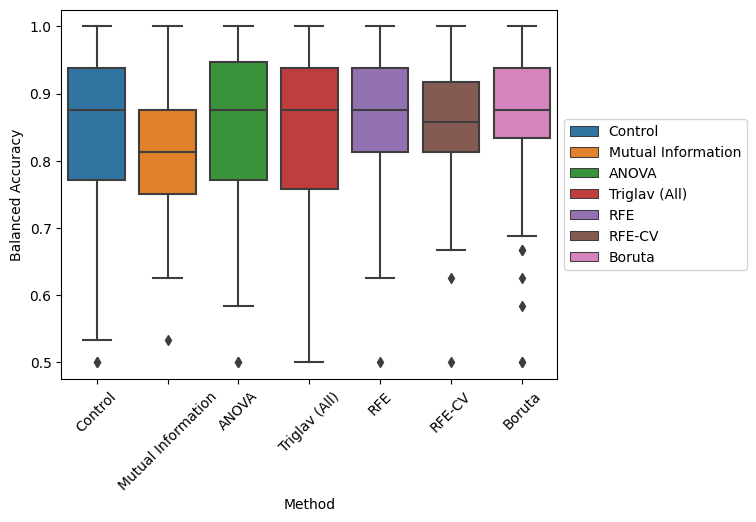

In [18]:
    ax = sns.boxplot(x = "Method", y = "Balanced Accuracy", hue = "Method", data = df, dodge = False)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation = 45)
    plt.show()
    plt.close()

#### Examine ANOVA and Triglav a little more since they both produced stable feature sets

In [19]:
    anova_loc = np.where(df["Method"].values == "ANOVA", True, False)
    anova_ss = df[anova_loc]
    anova_mean = np.mean(anova_ss["Total Selected"])
    anova_std = np.std(anova_ss["Total Selected"], ddof = 1)

    print(anova_mean, anova_std)
    print(X_train.shape[1])

    t_loc = np.where(df["Method"].values == "Triglav (All)", True, False)
    t_ss = df[t_loc]
    t_mean = np.mean(t_ss["Total Selected"])
    t_std = np.std(t_ss["Total Selected"], ddof = 1)

    print(t_mean, t_std)
    print(X_train.shape[1])

266.34 43.099604619617416
938
229.64 18.43218126328105
938


### Triglav and ANOVA appear to be statistically significant and more stable than competing methods. ANOVA may work well with CLR transformed data but it cannot take into account dependencies between features. For example, in this experiment we used decision trees. These are naturally capable of modelling such dependencies. For example, the successful classification of Sample X may depend on the presence of feature 1 and the absence of feature 2. Of the remaining methods, Triglav selects a large number of features (229.64 +/- 18.43) and feature sets which are selected appear to be the stable across runs (95% CI of stability scores is 0.624-0.643). It should also be noted these features belong to clusters which are more impactful than random. A per-cluster analysis for the most impactful features was not performed in this notebook.

#### References

Rudar, J., Porter, T.M., Wright, M., Golding G.B., Hajibabaei, M. LANDMark: an ensemble 
approach to the supervised selection of biomarkers in high-throughput sequencing data. 
BMC Bioinformatics 23, 110 (2022). https://doi.org/10.1186/s12859-022-04631-z

Pedregosa F, Varoquaux G, Gramfort A, Michel V, Thirion B, Grisel O, et al. Scikit-learn: 
Machine Learning in Python. Journal of Machine Learning Research. 2011;12:2825–30. 

Geurts P, Ernst D, Wehenkel L. Extremely Randomized Trees. Machine Learning. 2006;63(1):3–42.

Rudar, J., Golding, G.B., Kremer, S.C., Hajibabaei, M. (2023). Decision Tree Ensembles Utilizing 
Multivariate Splits Are Effective at Investigating Beta Diversity in Medically Relevant 16S Amplicon 
Sequencing Data. Microbiology Spectrum e02065-22.

Porter, T. M., & Hajibabaei, M. (2022). MetaWorks: A flexible, scalable bioinformatic pipeline for high-throughput multi-marker 
biodiversity assessments. PLOS ONE, 17(9), e0274260. doi: 10.1371/journal.pone.0274260

Wang, Q., Garrity, G. M., Tiedje, J. M., & Cole, J. R. (2007). Naive Bayesian Classifier for Rapid Assignment of rRNA Sequences into the New Bacterial Taxonomy. Applied and Environmental Microbiology, 73(16), 5261–5267. doi:10.1128/AEM.00062-07

Forbes JD, Chen C-Y, Knox NC, Marrie R-A, El-Gabalawy H, de Kievit T, et al. A comparative study of the gut microbiota in immune-mediated inflammatory diseases-does a common dysbiosis exist? Microbiome. 2018 Dec 13;6(1):221–221.

The scikit-bio development team (2020). scikit-bio: A Bioinformatics Library for Data Scientists, Students, and Developers. http://scikit-bio.org. version 0.5.8.
        
Sarah Nogueira, Konstantinos Sechidis, Gavin Brown (2017). On the Stability of Feature Selection. Journal of Machine Learning Reasearch (JMLR). 2017.